## Imports

In [1]:
import datetime
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from sklearn.metrics import confusion_matrix, f1_score
from torch.utils.data import ConcatDataset, DataLoader, WeightedRandomSampler

from utils.dataset import *
import utils.dataset as ds
from utils.model import ConvNet
from utils.plots import *
import utils.plots as plts
from utils.transforms import *
import utils.transforms as tf

import importlib
importlib.reload(tf)
importlib.reload(ds)
importlib.reload(plts)

<module 'utils.plots' from 'c:\\Users\\Jannis\\Development\\wisemat-posture-classification\\utils\\plots.py'>

## Hyper Parameters

In [13]:
num_trainings = 1
num_epochs = 2
learning_rate = 0.005
batch_size = 32
num_classes = len(PostureClass)

transform = torchvision.transforms.Compose(
    [
        Resize((32, 64), cv2.INTER_LINEAR),
        Normalize(),
        EqualizeHist(),
        Blur((5, 5)),
        Erode(),
        # Threshold(),
        Resize((64, 128), cv2.INTER_LINEAR),
        ToTensor(),
    ]
)

## Data Preparation

In [14]:
train_dataset = ConcatDataset(
    [
        PhysionetDataset(transform, train=True),
        SLPDataset(transform, train=True),
    ]
)

test_dataset = ConcatDataset(
    [
        PhysionetDataset(transform, train=False),
        SLPDataset(transform, train=False),
    ]
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Over- & Undersampling
train_labels = np.concatenate(
    list(map(lambda dataset: dataset.y, train_dataset.datasets))
)
test_labels = np.concatenate(
    list(map(lambda dataset: dataset.y, test_dataset.datasets))
)
_, train_class_counts = np.unique(train_labels, return_counts=True)
_, test_class_counts = np.unique(test_labels, return_counts=True)
weights = np.asarray([1.0 / train_class_counts[c] for c in train_labels])
train_sampler = WeightedRandomSampler(
    weights=weights, num_samples=len(weights), replacement=True
)

Number of training samples: 23556
Number of testing samples: 9796


## Train loop

In [15]:
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True#, sampler=train_sampler
)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels = labels.long()
        # print(images.shape) # torch.Size([4, 1, 64, 32])
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images.unsqueeze(1)) # Bring grayscale images form usual format (64x32) to a format with additional channel (1x64x32) (https://stackoverflow.com/questions/57237381/runtimeerror-expected-4-dimensional-input-for-4-dimensional-weight-32-3-3-but)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 50 == 0:
            print(
                f"Epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}"
            )

Epoch 1 / 2, step 50/737, loss = 1.0541
Epoch 1 / 2, step 100/737, loss = 1.0746
Epoch 1 / 2, step 150/737, loss = 1.0882
Epoch 1 / 2, step 200/737, loss = 1.0772
Epoch 1 / 2, step 250/737, loss = 0.9579
Epoch 1 / 2, step 300/737, loss = 0.8728
Epoch 1 / 2, step 350/737, loss = 0.5793
Epoch 1 / 2, step 400/737, loss = 0.4816
Epoch 1 / 2, step 450/737, loss = 0.2550
Epoch 1 / 2, step 500/737, loss = 0.3375
Epoch 1 / 2, step 550/737, loss = 0.2314
Epoch 1 / 2, step 600/737, loss = 0.3142
Epoch 1 / 2, step 650/737, loss = 0.1899
Epoch 1 / 2, step 700/737, loss = 0.1738
Epoch 2 / 2, step 50/737, loss = 0.1549
Epoch 2 / 2, step 100/737, loss = 0.2784
Epoch 2 / 2, step 150/737, loss = 0.2604
Epoch 2 / 2, step 200/737, loss = 0.7648
Epoch 2 / 2, step 250/737, loss = 0.4030
Epoch 2 / 2, step 300/737, loss = 0.1219
Epoch 2 / 2, step 350/737, loss = 0.0173
Epoch 2 / 2, step 400/737, loss = 0.0951
Epoch 2 / 2, step 450/737, loss = 0.1266
Epoch 2 / 2, step 500/737, loss = 0.1654
Epoch 2 / 2, step 

## Evaluation

Normalized confusion matrix


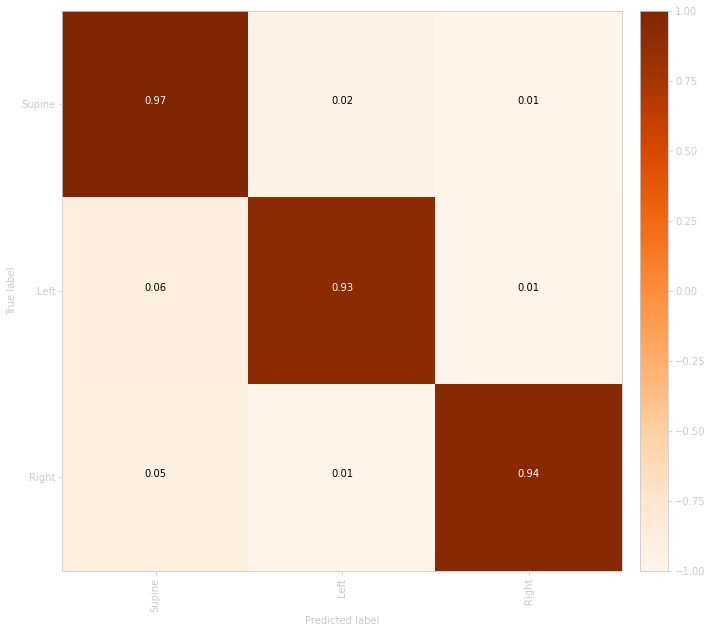

In [16]:
model.eval()
predlist = []
lbllist = []
acc = 0.0
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.unsqueeze(1))

        _, predictions = torch.max(outputs, 1)

        lbllist.append(labels.cpu().numpy())
        predlist.append(predictions.cpu().numpy())
        n_samples += labels.size(0)
        n_correct += (predictions == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    conf_mat = confusion_matrix(np.concatenate(lbllist), np.concatenate(predlist))

    # print(f1_score(np.concatenate(lbllist), np.concatenate(predlist), average='macro'))
    # print(f1_score(np.concatenate(lbllist), np.concatenate(predlist), average=None))

folder: Path = Path("models").joinpath("autosave").joinpath(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
Path.mkdir(folder, parents=True, exist_ok=True)
torch.save(model.state_dict(), folder.joinpath("model.pt"))
with open(folder.joinpath("hyperparams.txt"), "w") as file:
    file.write(f"learning_rate = {learning_rate}\n")
    file.write(f"num_epochs = {num_epochs}\n")
    file.write(f"batch_size = {batch_size}\n")
    file.write(f"{str(transform.transforms)}\n")
    file.write(f"{str(train_dataset.datasets)}\n")
np.save(folder.joinpath("confmat.npy"), conf_mat)
plot_confusion_matrix(conf_mat, normalize=True)